In [ ]:
# Install folktables
!pip install folktables pandas numpy

import pandas as pd
import numpy as np
from folktables import ACSDataSource

# Define the latest available year
latest_year = 2023

# List of all U.S. states (excluding territories)
states_list = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA",
    "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK",
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

# Define potential features and target for socioeconomic status prediction
all_features = [
    "AGEP",  # Age
    "SEX",  # Gender
    "RAC1P",  # Race
    "SCHL",  # Education Level
    "MAR",  # Marital Status
    "OCCP",  # Occupation Code
    "WKHP",  # Work Hours per Week
    "COW",  # Class of Worker (Private, Self-employed, etc.)
    "POBP",  # Place of Birth
    "RELP",  # Relationship (Head of Household, Child, etc.)
]

target = "PINCP"  # Personal Income

# Process data in chunks of 5 states at a time
batch_size = 5
for i in range(0, len(states_list), batch_size):
    batch_states = states_list[i:i + batch_size]

    # Load data from ACS survey for the batch of states
    data_source = ACSDataSource(survey_year=latest_year, horizon="1-Year", survey="person")
    acs_data = data_source.get_data(states=batch_states, download=True)

    # Print available columns (debugging step)
    print(f"Available columns for {batch_states}:")
    print(list(acs_data.columns))

    # Filter features that are actually present in the dataset
    available_features = [col for col in all_features if col in acs_data.columns]

    # Convert to Pandas DataFrame
    df = acs_data[available_features + [target]].dropna()  # Drop missing values

    # Convert target into binary classification: Income > $50K = 1, else 0
    df["Income_Above_50K"] = (df["PINCP"] > 50000).astype(int)

    # Drop original income column
    df = df.drop(columns=["PINCP"])

    # Save the chunk as a CSV file
    file_name = f"census_data_{'_'.join(batch_states)}.csv"
    df.to_csv(file_name, index=False)

    print(f"✅ Processed and saved: {file_name} | Shape: {df.shape}")


Available columns for ['AL', 'AK', 'AZ', 'AR', 'CA']:
['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'STATE', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'FER', 'GCL', 'GCM', 'GCR', 'HIMRKS', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7', 'INTP', 'JWMNP', 'JWRIP', 'JWTRNS', 'LANX', 'MAR', 'MARHD', 'MARHM', 'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPIK', 'MLPJ', 'NWAB', 'NWAV', 'NWLA', 'NWLK', 'NWRE', 'OIP', 'PAP', 'RELSHIPP', 'RETP', 'SCH', 'SCHG', 'SCHL', 'SEMP', 'SEX', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKWN', 'WRK', 'YOEP', 'ANC', 'ANC1P', 'ANC2P', 'DECADE', 'DIS', 'DRIVESP', 'ESP', 'ESR', 'FOD1P', 'FOD2P', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'MSP', 'NAICSP', 'NATIVITY', 'NOP', 'OC', 'OCCP', 'PAOC', 'PERNP', 'PINCP', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP', 'PRIVCOV', 'PUBCOV', 'QTRBIR', 'RAC

In [1]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

file_path = "final_census_dataset(1).csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info()

# Display the first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754520 entries, 0 to 1754519
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   AGEP              int64  
 1   SEX               int64  
 2   RAC1P             int64  
 3   SCHL              float64
 4   MAR               int64  
 5   OCCP              float64
 6   WKHP              float64
 7   COW               float64
 8   POBP              int64  
 9   Income_Above_50K  int64  
dtypes: float64(4), int64(6)
memory usage: 133.9 MB


,AGEP,SEX,RAC1P,SCHL,MAR,OCCP,WKHP,COW,POBP,Income_Above_50K
0,20,2,2,19.0,5,5310.0,15.0,1.0,18,0
1,18,1,1,16.0,5,4010.0,40.0,1.0,24,0
2,18,1,2,18.0,5,3960.0,30.0,1.0,51,0
3,38,1,1,13.0,3,4720.0,48.0,1.0,51,0
4,21,2,1,19.0,5,4760.0,30.0,1.0,51,0


In [2]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
AGEP                0
SEX                 0
RAC1P               0
SCHL                0
MAR                 0
OCCP                0
WKHP                0
COW                 0
POBP                0
Income_Above_50K    0
dtype: int64


In [3]:
df.shape

(1754520, 10)

In [4]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
               AGEP           SEX         RAC1P          SCHL           MAR  \
count  1.754520e+06  1.754520e+06  1.754520e+06  1.754520e+06  1.754520e+06   
mean   4.340636e+01  1.480710e+00  2.742375e+00  1.866646e+01  2.589754e+00   
std    1.569629e+01  4.996279e-01  2.954003e+00  3.479900e+00  1.823308e+00   
min    1.600000e+01  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    3.000000e+01  1.000000e+00  1.000000e+00  1.600000e+01  1.000000e+00   
50%    4.300000e+01  1.000000e+00  1.000000e+00  1.900000e+01  1.000000e+00   
75%    5.600000e+01  2.000000e+00  2.000000e+00  2.100000e+01  5.000000e+00   
max    9.600000e+01  2.000000e+00  9.000000e+00  2.400000e+01  5.000000e+00   

               OCCP          WKHP           COW          POBP  \
count  1.754520e+06  1.754520e+06  1.754520e+06  1.754520e+06   
mean   4.005421e+03  3.768259e+01  2.116980e+00  6.817675e+01   
std    2.710624e+03  1.316483e+01  1.835302e+00  9.610705e+01   
min    

In [21]:
df.AGEP.max()

96

In [5]:
df.SEX.value_counts()

,count
SEX,
1,911104
2,843416


<ipython-input-15-2f1c86315663>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=income_counts.index, y=income_counts.values, palette="coolwarm", edgecolor="black")


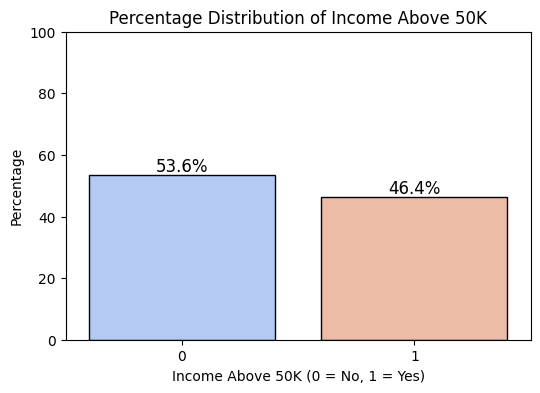

In [15]:
# Calculate percentage distribution of Income_Above_50K
income_counts = df["Income_Above_50K"].value_counts(normalize=True) * 100

# Plot bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=income_counts.index, y=income_counts.values, palette="coolwarm", edgecolor="black")

# Add labels and title
plt.xlabel("Income Above 50K (0 = No, 1 = Yes)")
plt.ylabel("Percentage")
plt.title("Percentage Distribution of Income Above 50K")
plt.ylim(0, 100)  # Scale from 0% to 100%

# Show percentages on top of bars
for i, value in enumerate(income_counts.values):
    plt.text(i, value + 1, f"{value:.1f}%", ha="center", fontsize=12)

# Show plot
plt.show()


<Figure size 1200x800 with 0 Axes>

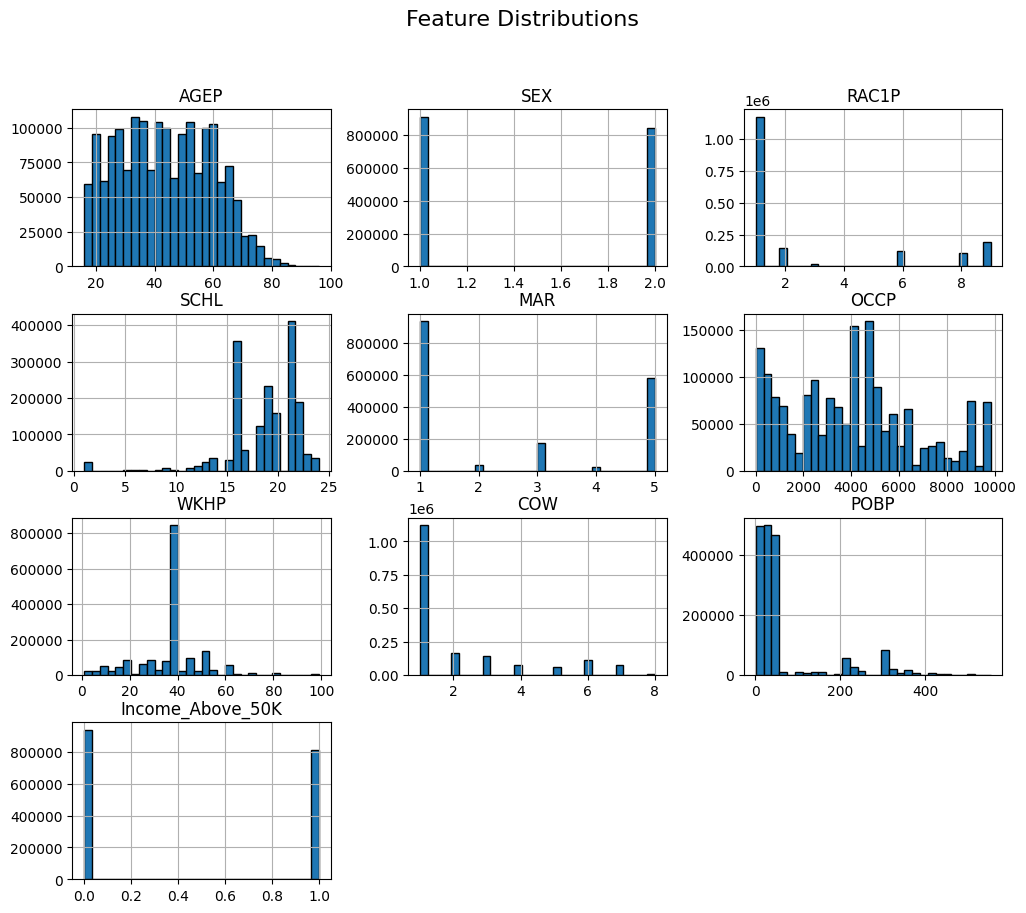

In [16]:
# Visualizing Distributions

plt.figure(figsize=(12, 8))
df.hist(bins=30, figsize=(12, 10), edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)

plt.savefig("feature_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-7-1f8484208a32>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis', edgecolor="black")
<ipython-input-7-1f8484208a32>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis', edgecolor="black")
<ipython-input-7-1f8484208a32>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis', edgecolor="black")
<ipython-input-7-1f8484208a32>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

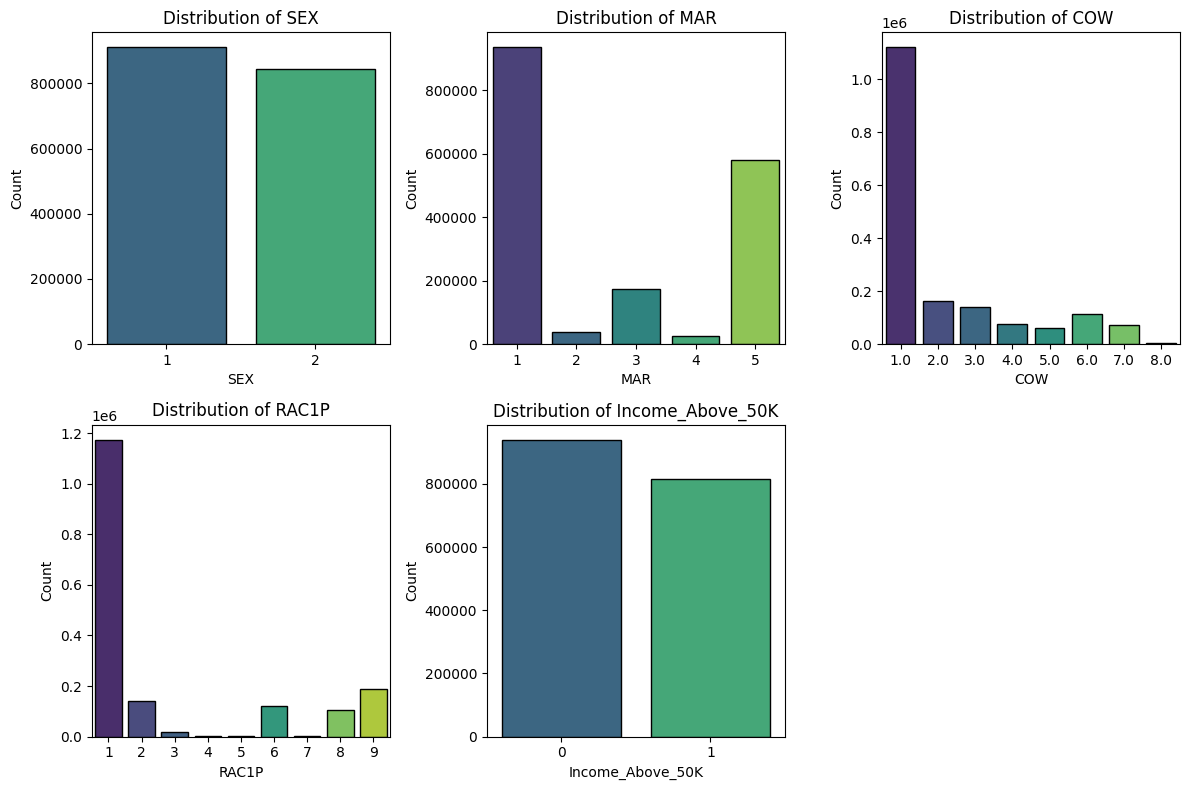

In [7]:
# Categorical Feature Analysis

plt.figure(figsize=(12, 8))

# List of categorical columns to analyze
categorical_columns = ['SEX', 'MAR', 'COW', 'RAC1P', 'Income_Above_50K']

# Create subplots for each categorical variable
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=df[col], palette='viridis', edgecolor="black")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


<ipython-input-8-c7af9fd793c0>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Income_Above_50K', y='SCHL', data=df, palette='coolwarm')


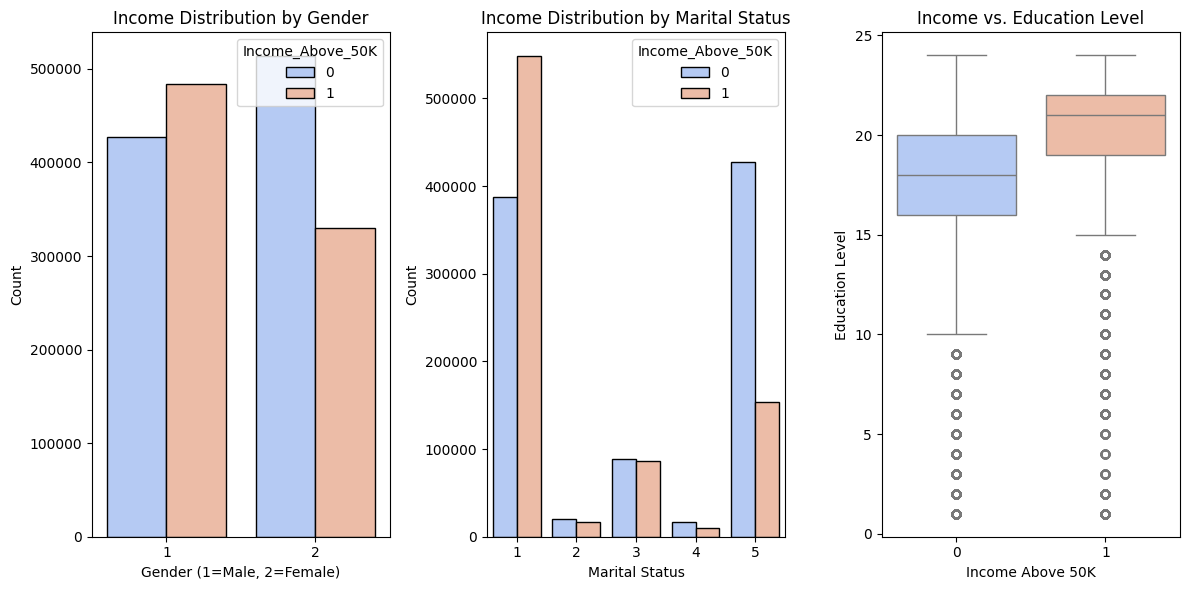

In [8]:
# Income vs. Other Features
plt.figure(figsize=(12, 6))

# Income vs. Gender
plt.subplot(1, 3, 1)
sns.countplot(x='SEX', hue='Income_Above_50K', data=df, palette='coolwarm', edgecolor="black")
plt.title("Income Distribution by Gender")
plt.xlabel("Gender (1=Male, 2=Female)")
plt.ylabel("Count")
# Income vs. Marital Status
plt.subplot(1, 3, 2)
sns.countplot(x='MAR', hue='Income_Above_50K', data=df, palette='coolwarm', edgecolor="black")
plt.title("Income Distribution by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")

# Income vs. Education Level
plt.subplot(1, 3, 3)
sns.boxplot(x='Income_Above_50K', y='SCHL', data=df, palette='coolwarm')
plt.title("Income vs. Education Level")
plt.xlabel("Income Above 50K")
plt.ylabel("Education Level")


# Adjust layout
plt.tight_layout()
plt.show()


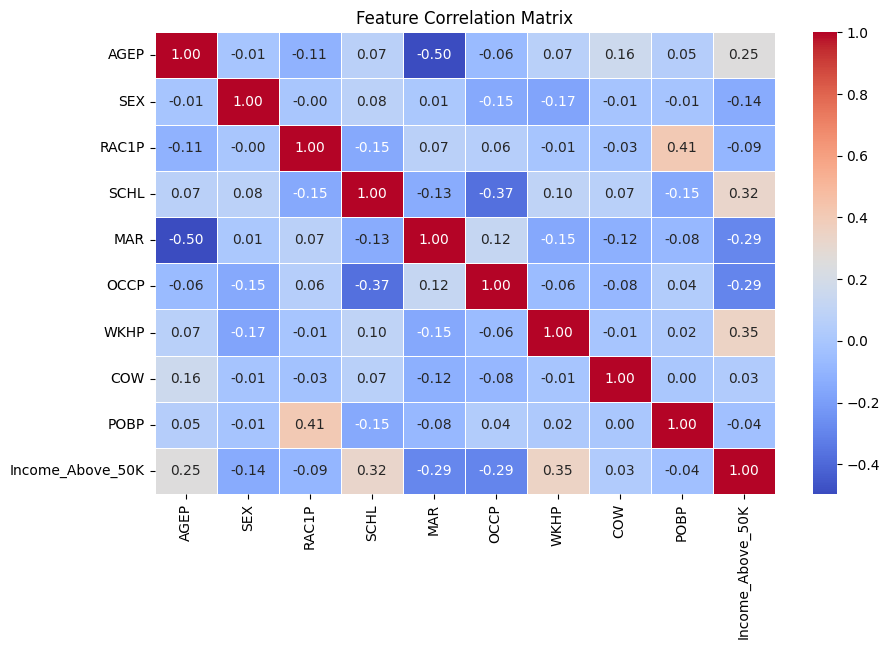

In [9]:
# Correlation Analysis

# Compute correlation matrix
correlation_matrix = df.corr()

# Set figure size
plt.figure(figsize=(10, 6))

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Set title
plt.title("Feature Correlation Matrix")

# Show plot
plt.show()

In [10]:

# Define features (X) and target variable (y)
X = df.drop(columns=["Income_Above_50K"])  # Drop target column
y = df["Income_Above_50K"]  # Target variable

# Train-Test Split (to avoid data leakage in feature importance analysis)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model for feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importance ranking
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Display feature importance ranking
print(feature_importance_df)


  Feature  Importance
5    OCCP    0.254447
0    AGEP    0.193636
8    POBP    0.155516
6    WKHP    0.147485
3    SCHL    0.113951
4     MAR    0.046085
7     COW    0.038238
2   RAC1P    0.028700
1     SEX    0.021942


In [11]:

# Select only the top 5 important features
selected_features = ["OCCP", "AGEP", "POBP", "WKHP", "SCHL"]
X_selected = df[selected_features]  # Feature matrix
y = df["Income_Above_50K"]  # Target variable

# Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train Logistic Regression Model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

# Make Predictions
y_pred = logreg_model.predict(X_test)

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print Results
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_rep)


Model Accuracy: 0.7519

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77    188262
           1       0.73      0.74      0.73    162642

    accuracy                           0.75    350904
   macro avg       0.75      0.75      0.75    350904
weighted avg       0.75      0.75      0.75    350904



In [12]:
# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make Predictions - Decision Tree
y_pred_dt = dt_model.predict(X_test)

# Evaluate Decision Tree Performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print("\nDecision Tree Classification Report:\n", classification_rep_dt)

Decision Tree Accuracy: 0.7287

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75    188262
           1       0.71      0.70      0.70    162642

    accuracy                           0.73    350904
   macro avg       0.73      0.73      0.73    350904
weighted avg       0.73      0.73      0.73    350904



In [13]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions - Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest Performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")
print("\nRandom Forest Classification Report:\n", classification_rep_rf)


Random Forest Accuracy: 0.7736

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79    188262
           1       0.76      0.76      0.76    162642

    accuracy                           0.77    350904
   macro avg       0.77      0.77      0.77    350904
weighted avg       0.77      0.77      0.77    350904

